In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# GET THE DATASETS

In [2]:
# MARKETING FUNNEL DATASETS
# https://www.kaggle.com/datasets/olistbr/marketing-funnel-olist/data
path = kagglehub.dataset_download("olistbr/marketing-funnel-olist")
files = os.listdir(path)
print("Files in dataset folder:", files)

# Dictionary to hold DataFrames
dataframes = {}
for file in files:
    if file.endswith('.csv'):
        # Get filename without extension to use as key
        name = os.path.splitext(file)[0]        
        # Read CSV file into DataFrame
        df = pd.read_csv(os.path.join(path, file))
        # Store DataFrame in dictionary
        dataframes[name] = df

Files in dataset folder: ['olist_marketing_qualified_leads_dataset.csv', 'olist_closed_deals_dataset.csv']


In [3]:
# Leads dataframe
leads = dataframes['olist_marketing_qualified_leads_dataset']
print("Leads:", leads.shape, '\nLeads columns:', leads.columns)

# Deals dataframe
deals = dataframes['olist_closed_deals_dataset']
print("Closed Deals:", deals.shape, '\nClosed Deals columns:', deals.columns)

Leads: (8000, 4) 
Leads columns: Index(['mql_id', 'first_contact_date', 'landing_page_id', 'origin'], dtype='object')
Closed Deals: (842, 14) 
Closed Deals columns: Index(['mql_id', 'seller_id', 'sdr_id', 'sr_id', 'won_date',
       'business_segment', 'lead_type', 'lead_behaviour_profile',
       'has_company', 'has_gtin', 'average_stock', 'business_type',
       'declared_product_catalog_size', 'declared_monthly_revenue'],
      dtype='object')


# JOIN THE DATAFRAMES

In [4]:
# Check unique values in 'mql_id' column
print("Unique values in 'mql_id' column from Leads:", leads['mql_id'].nunique())
print("Unique values in 'mql_id' column from Closed Deals:", deals['mql_id'].nunique())

Unique values in 'mql_id' column from Leads: 8000
Unique values in 'mql_id' column from Closed Deals: 842


In [5]:
df_final = pd.merge(leads, deals, how='left', on='mql_id')
print("Final DataFrame shape:", df_final.shape)
print("Final DataFrame columns:", df_final.columns)
print("Records from Closed Deals in Final DataFrame:", df_final['seller_id'].notna().sum())

Final DataFrame shape: (8000, 17)
Final DataFrame columns: Index(['mql_id', 'first_contact_date', 'landing_page_id', 'origin',
       'seller_id', 'sdr_id', 'sr_id', 'won_date', 'business_segment',
       'lead_type', 'lead_behaviour_profile', 'has_company', 'has_gtin',
       'average_stock', 'business_type', 'declared_product_catalog_size',
       'declared_monthly_revenue'],
      dtype='object')
Records from Closed Deals in Final DataFrame: 842


# EXPLORE THE DATA

In [6]:
# Consistency checks
print("Column types in Final DataFrame:\n",df_final.dtypes)
print("\nDuplicate records in Final DataFrame:", df_final.duplicated().sum())
print("\nMissing values in Final DataFrame:\n",df_final.isnull().sum())
print("\nSummary statistics of Final DataFrame:")
df_final.describe()

Column types in Final DataFrame:
 mql_id                            object
first_contact_date                object
landing_page_id                   object
origin                            object
seller_id                         object
sdr_id                            object
sr_id                             object
won_date                          object
business_segment                  object
lead_type                         object
lead_behaviour_profile            object
has_company                       object
has_gtin                          object
average_stock                     object
business_type                     object
declared_product_catalog_size    float64
declared_monthly_revenue         float64
dtype: object

Duplicate records in Final DataFrame: 0

Missing values in Final DataFrame:
 mql_id                              0
first_contact_date                  0
landing_page_id                     0
origin                             60
seller_id                

,declared_product_catalog_size,declared_monthly_revenue
count,69.000000,8.420000e+02
mean,233.028986,7.337768e+04
std,352.380558,1.744799e+06
min,1.000000,0.000000e+00
25%,30.000000,0.000000e+00
50%,100.000000,0.000000e+00
75%,300.000000,0.000000e+00
max,2000.000000,5.000000e+07


In [8]:
# Check for unique values in categorical columns
categorical_columns = df_final.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df_final[col].nunique()
    print(f"Unique values in {col}: {unique_values}")
    if unique_values <= 10:
        print(f"List of values in {col}:", df_final[col].unique())

Unique values in mql_id: 8000
Unique values in first_contact_date: 336
Unique values in landing_page_id: 495
Unique values in origin: 10
List of values in origin: ['social' 'paid_search' 'organic_search' 'email' 'unknown' 'referral'
 'direct_traffic' 'display' nan 'other_publicities' 'other']
Unique values in seller_id: 842
Unique values in sdr_id: 32
Unique values in sr_id: 22
Unique values in won_date: 824
Unique values in business_segment: 33
Unique values in lead_type: 8
List of values in lead_type: [nan 'online_medium' 'industry' 'online_big' 'online_small' 'offline'
 'online_top' 'online_beginner' 'other']
Unique values in lead_behaviour_profile: 9
List of values in lead_behaviour_profile: [nan 'cat' 'eagle' 'wolf' 'shark' 'cat, wolf' 'eagle, wolf' 'shark, cat'
 'eagle, cat' 'shark, wolf']
Unique values in has_company: 2
List of values in has_company: [nan True False]
Unique values in has_gtin: 2
List of values in has_gtin: [nan True False]
Unique values in average_stock: 6
List 

In [9]:
# Check for outliers in numerical columns
numerical_columns = df_final.select_dtypes(include=['number']).columns
for col in numerical_columns:
    q1 = df_final[col].quantile(0.25)
    q3 = df_final[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df_final[(df_final[col] < lower_bound) | (df_final[col] > upper_bound)]
    print(f"Outliers in {col}: {outliers.shape[0]}")

Outliers in declared_product_catalog_size: 6
Outliers in declared_monthly_revenue: 45


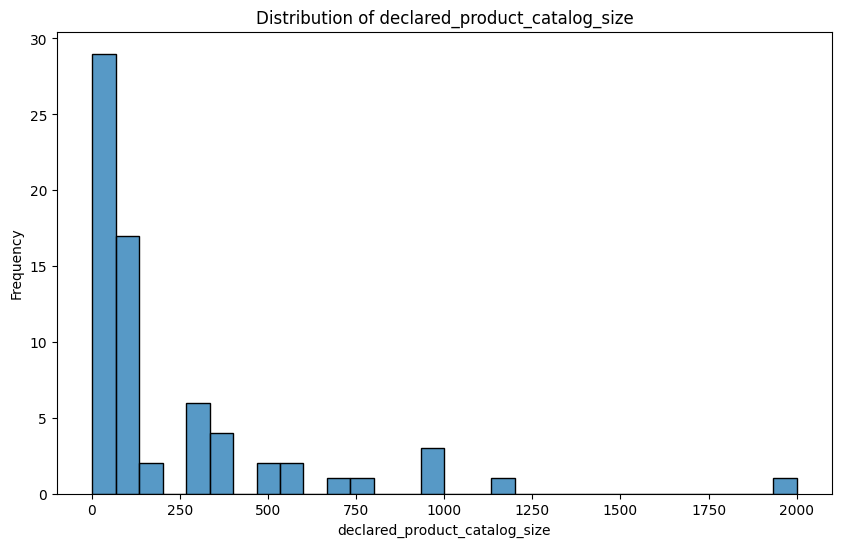

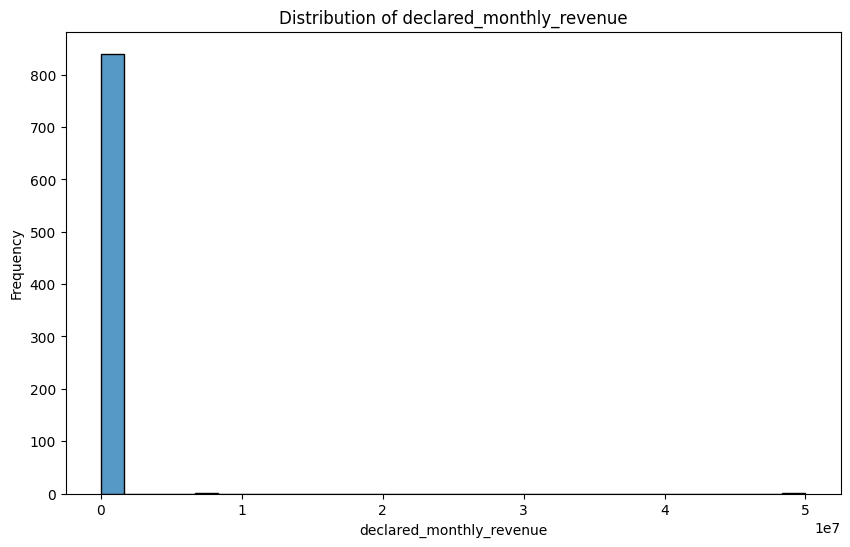

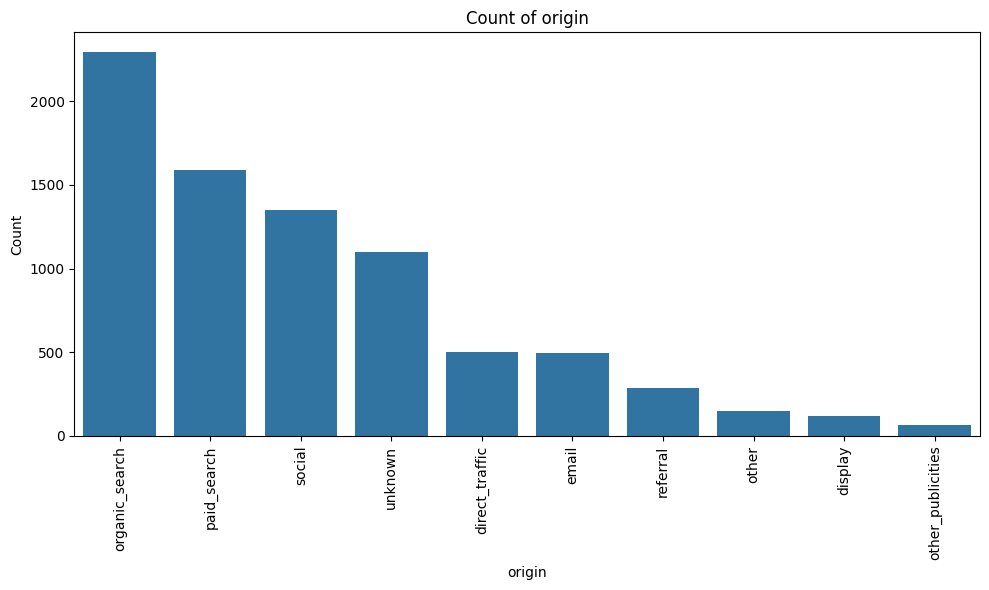

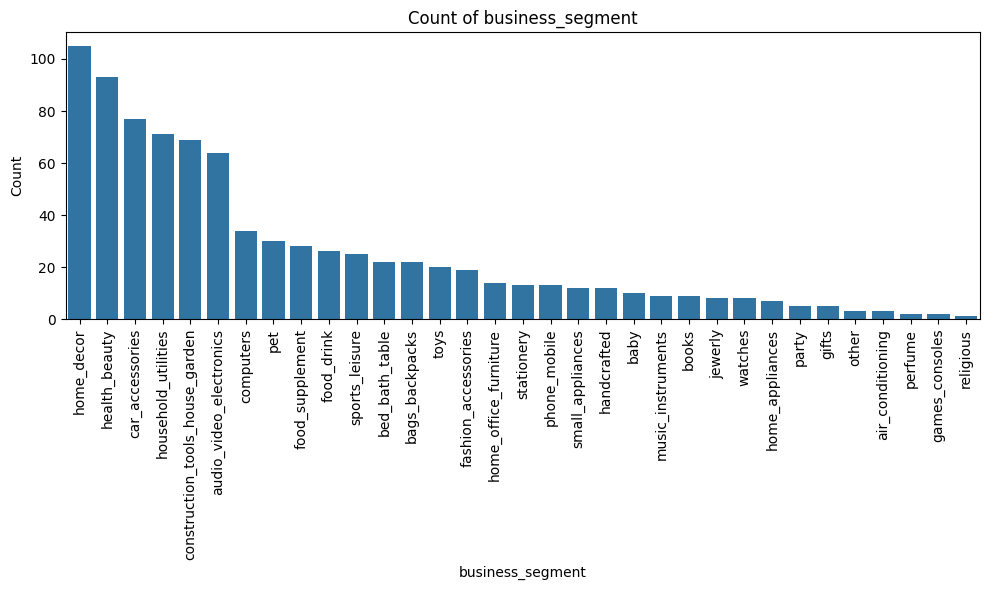

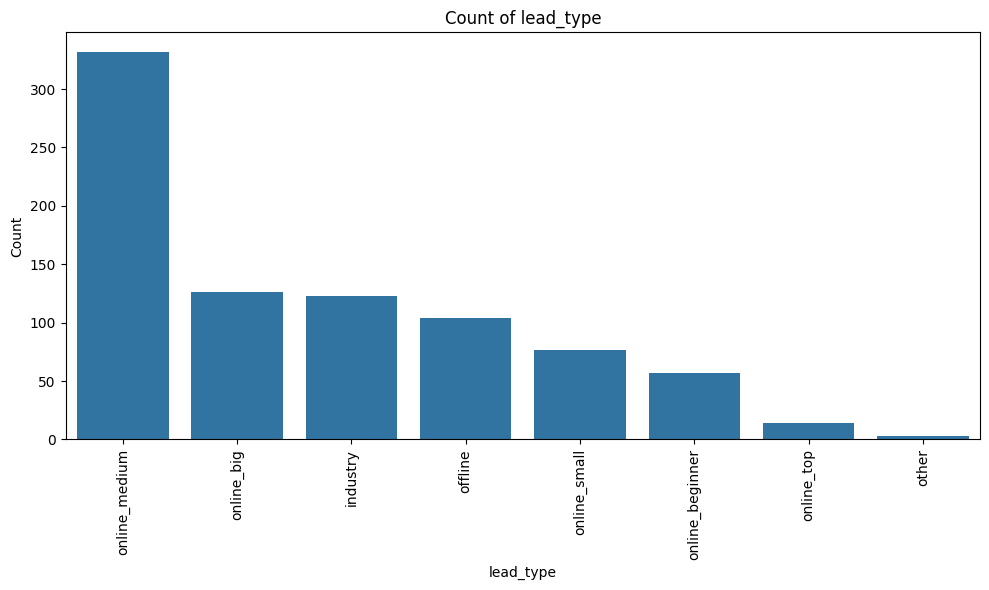

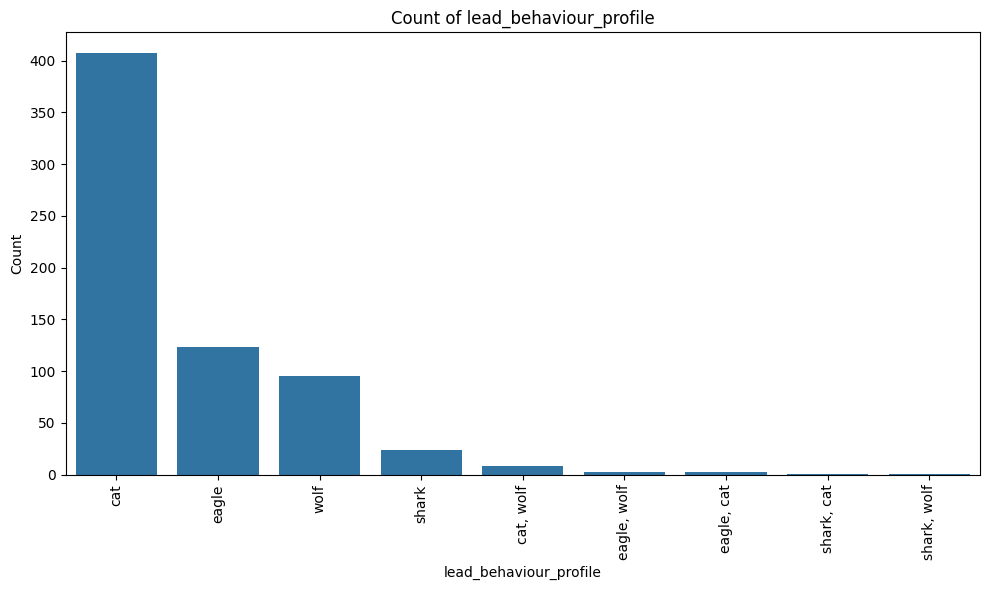

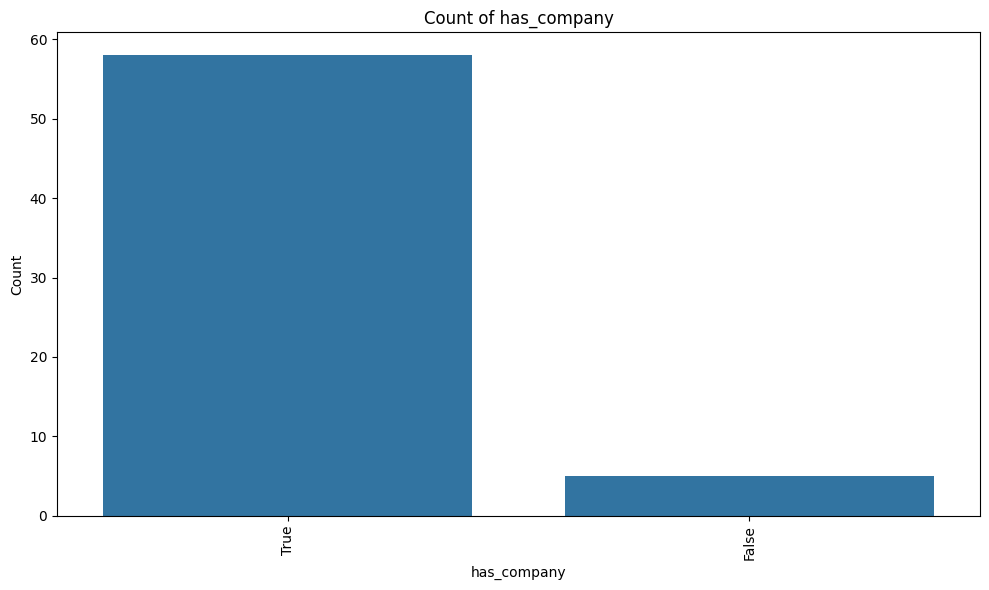

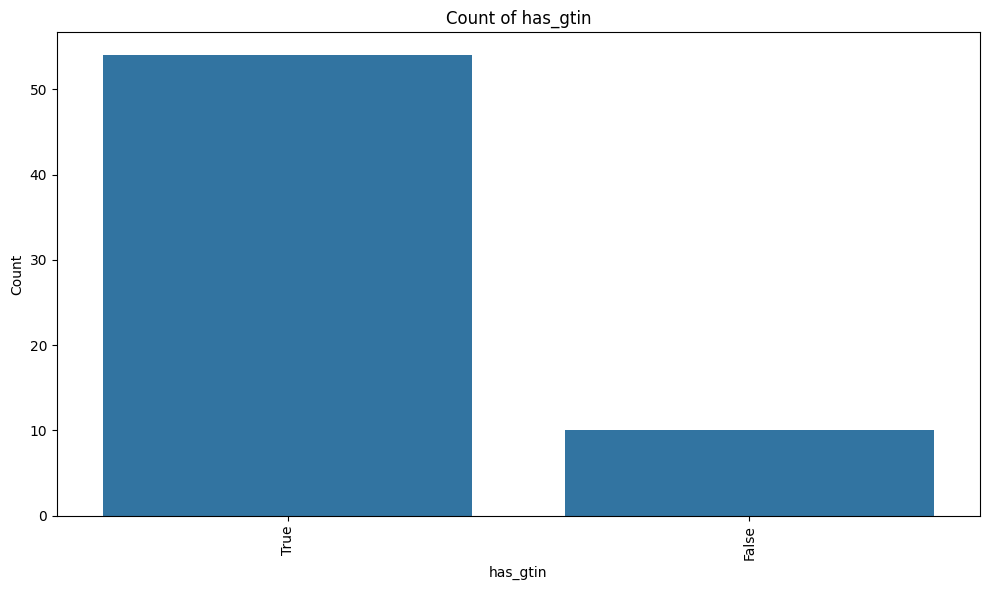

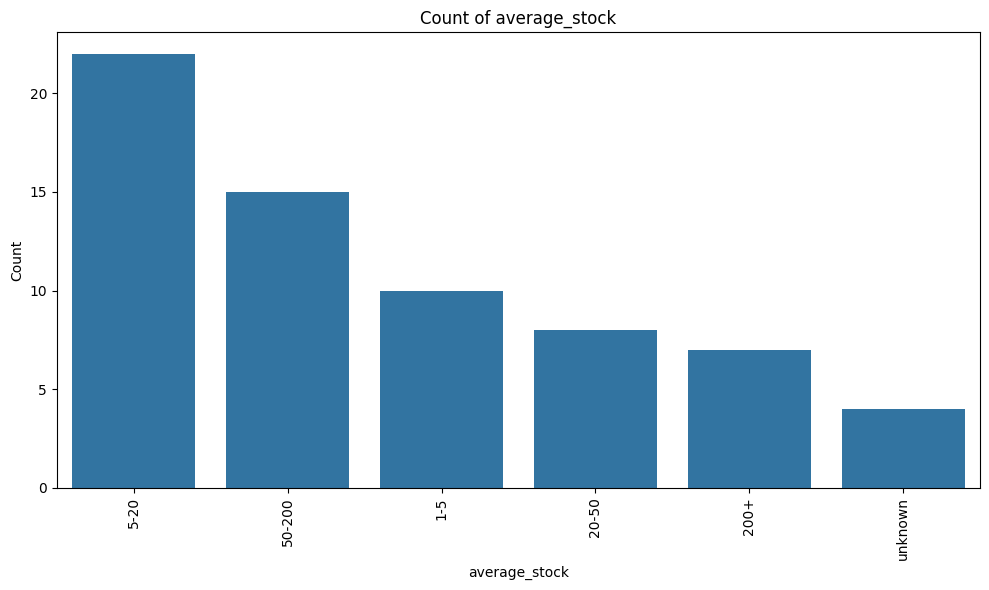

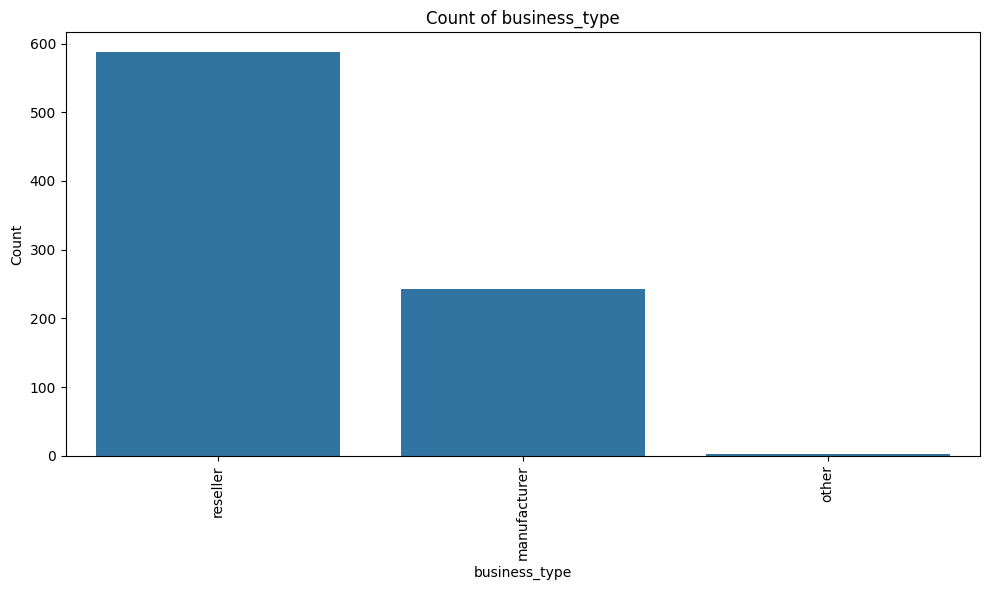

In [10]:
# Visualize distributions of numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_final[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

exclude=['mql_id','landing_page_id','seller_id','sdr_id','sr_id','first_contact_date','won_date',]
categorical_columns = [col for col in categorical_columns if col not in exclude]
# Visualize categorical columns
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    # sort by count
    order = df_final[col].value_counts().index
    sns.countplot(data=df_final, x=col, order=order)
    plt.title(f"Count of {col}")
    # adjust size of x-axis labels
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# KEY CHALLENGES

## Conversion Rates

In [7]:
# Conversion rate
conversion_rate = df_final['seller_id'].notna().sum() / df_final['mql_id'].nunique()
print(f"Overall Conversion Rate: {conversion_rate:.2%}")

# Conversion rate by channel
print("\nConversion Rate (CR) by Channel")
for channel in df_final['origin'].unique():
    channel_overall_weight = df_final[df_final['origin'] == channel]['mql_id'].nunique() / df_final['mql_id'].nunique()
    channel_weight = df_final[df_final['origin'] == channel]['seller_id'].nunique() / df_final['seller_id'].nunique()
    channel_conversion_rate = df_final[df_final['origin'] == channel]['seller_id'].notna().sum() / df_final[df_final['origin'] == channel]['mql_id'].nunique()
    if channel_weight > 0:
        print(f"Channel: {channel} | Overall Weight: {channel_overall_weight:.2%} | Weight: {channel_weight:.2%} | CR: {channel_conversion_rate:.2%}")


Overall Conversion Rate: 10.53%

Conversion Rate (CR) by Channel
Channel: social | Overall Weight: 16.88% | Weight: 8.91% | CR: 5.56%
Channel: paid_search | Overall Weight: 19.82% | Weight: 23.16% | CR: 12.30%
Channel: organic_search | Overall Weight: 28.70% | Weight: 32.19% | CR: 11.80%
Channel: email | Overall Weight: 6.16% | Weight: 1.78% | CR: 3.04%
Channel: unknown | Overall Weight: 13.74% | Weight: 21.26% | CR: 16.29%
Channel: referral | Overall Weight: 3.55% | Weight: 2.85% | CR: 8.45%
Channel: direct_traffic | Overall Weight: 6.24% | Weight: 6.65% | CR: 11.22%
Channel: display | Overall Weight: 1.47% | Weight: 0.71% | CR: 5.08%
Channel: other_publicities | Overall Weight: 0.81% | Weight: 0.36% | CR: 4.62%
Channel: other | Overall Weight: 1.88% | Weight: 0.48% | CR: 2.67%


/var/folders/xn/p3517whj0pq99ptx9zyp_p780000gn/T/ipykernel_7230/3045186466.py:10: RuntimeWarning: invalid value encountered in scalar divide
  channel_conversion_rate = df_final[df_final['origin'] == channel]['seller_id'].notna().sum() / df_final[df_final['origin'] == channel]['mql_id'].nunique()


## Attribution Model
Since we only have a single-touch model, we will use it to assing ROI and the already calculated CR

In [15]:
# Group by origin and sum number of leads, number of deals and revenue
df_grouped = df_final.groupby('origin').agg(
    num_leads=('mql_id', 'nunique'),
    num_deals=('seller_id', 'nunique'),
    revenue=('declared_monthly_revenue', 'sum'),
    conversion_rate=('seller_id', lambda x: x.notna().sum() / len(x)),
    revenue_per_lead=('declared_monthly_revenue', lambda x: x.sum() / len(x))
).reset_index()

df_grouped.sort_values(by='num_leads', ascending=False)

,origin,num_leads,num_deals,revenue,conversion_rate,revenue_per_lead
3,organic_search,2296,271,51426000.0,0.118031,22398.083624
6,paid_search,1586,195,9169000.0,0.122951,5781.210593
8,social,1350,75,501000.0,0.055556,371.111111
9,unknown,1099,179,463006.0,0.162875,421.297543
0,direct_traffic,499,56,60000.0,0.112224,120.240481
2,email,493,15,15000.0,0.030426,30.425963
7,referral,284,24,0.0,0.084507,0.000000
4,other,150,4,0.0,0.026667,0.000000
1,display,118,6,0.0,0.050847,0.000000
5,other_publicities,65,3,0.0,0.046154,0.000000


## Forecast future lead creation (next 3 months)

16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: direct_traffic


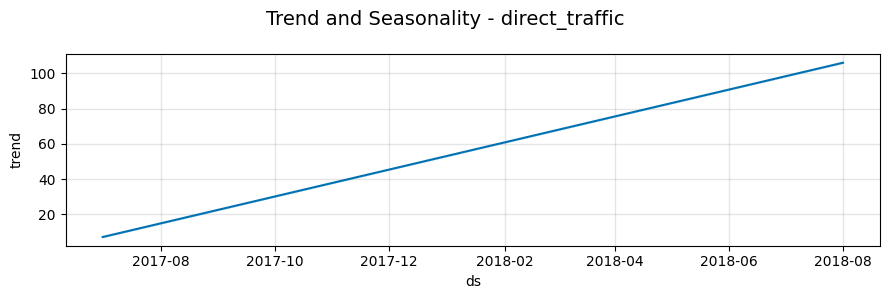

16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: display


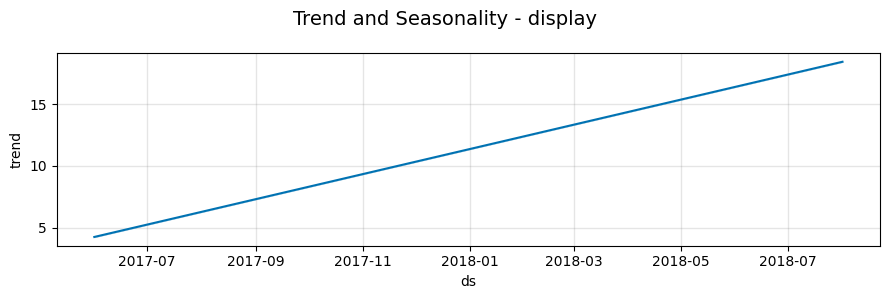

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: email


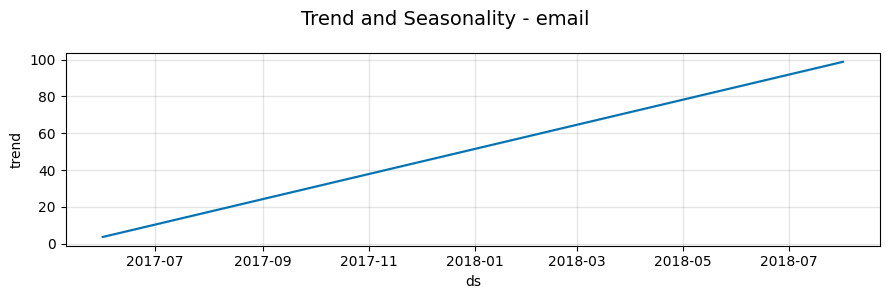

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: organic_search


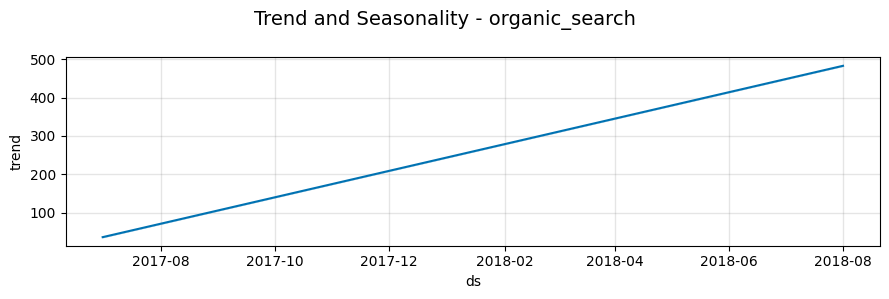

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: other


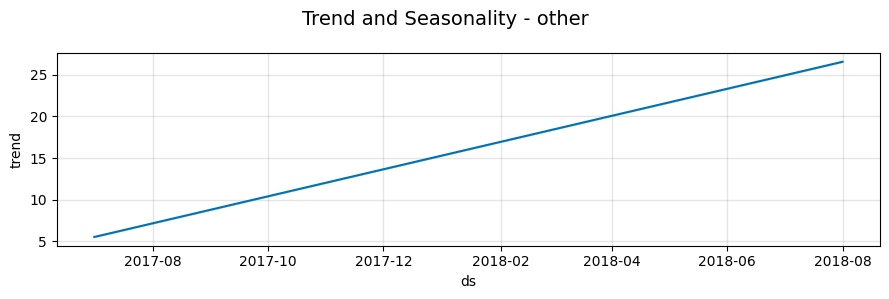

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: other_publicities


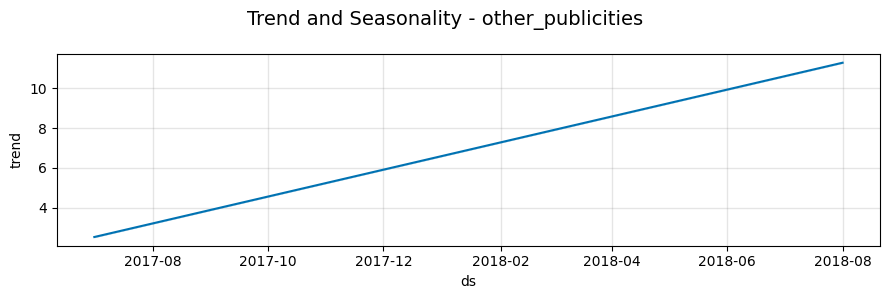

16:16:22 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for channel: paid_search


16:16:22 - cmdstanpy - INFO - Chain [1] done processing


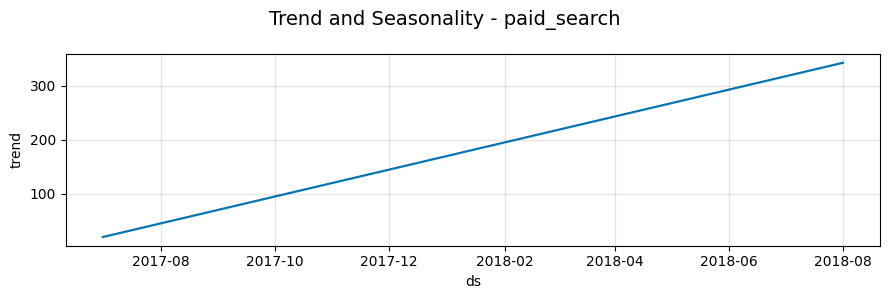

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: referral


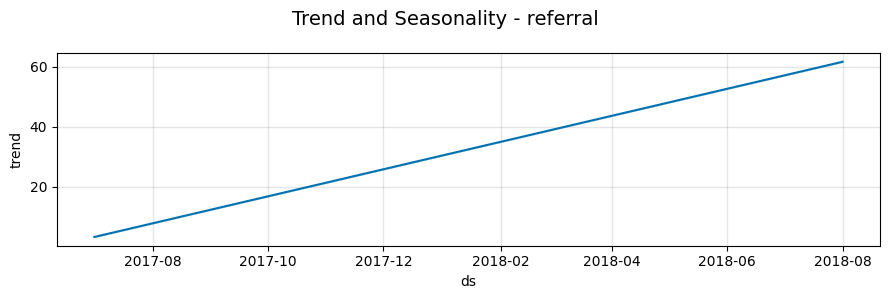

16:16:23 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for channel: social


16:16:23 - cmdstanpy - INFO - Chain [1] done processing


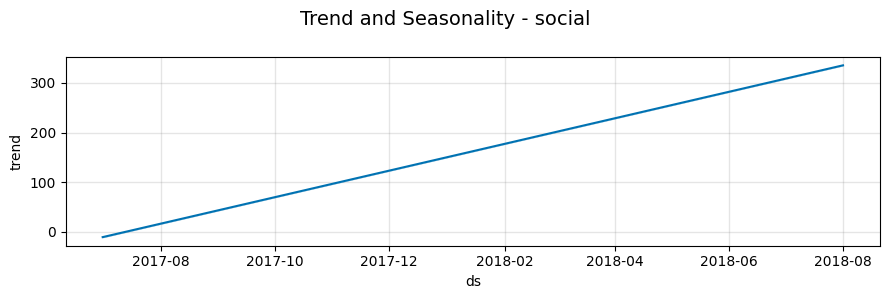

16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for channel: unknown


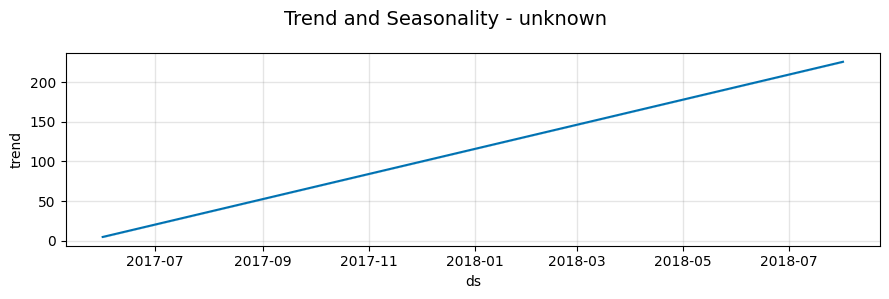

In [75]:
# Prepare data for modeling ['mql_id', 'first_contact_date', 'origin']
leads['month'] = pd.to_datetime(leads['first_contact_date']).dt.to_period('M').dt.to_timestamp()
leads_model = leads.groupby(['origin','month']).agg(num_leads=('mql_id', 'nunique')).reset_index()
leads_model['month'] = pd.to_datetime(leads_model['month'])

# Forecast each channel separately for 3 months ahead
forecasts = []
all_components = []

for channel in leads_model['origin'].unique():
    print(f"Forecasting for channel: {channel}")
    # Prepare data
    channel_df = leads_model[leads_model['origin'] == channel][['month', 'num_leads']].copy()
    channel_df.rename(columns={'month': 'ds', 'num_leads': 'y'}, inplace=True)

    # Initialize and fit model
    model = Prophet()
    model.fit(channel_df)

    # Forecast next 3 months
    future = model.make_future_dataframe(periods=3, freq='MS')
    forecast = model.predict(future)

    # 🔍 Analyze components (trend & seasonality)
    forecast['channel'] = channel
    components = model.plot_components(forecast)
    plt.suptitle(f"Trend and Seasonality - {channel}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 🔍 Only keep the forecast for the future (not historical predictions)
    forecast_future = forecast[forecast['ds'] > channel_df['ds'].max()].copy()
    forecasts.append(forecast_future[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'channel']])

# Combine forecasts across all channels
final_forecast = pd.concat(forecasts)

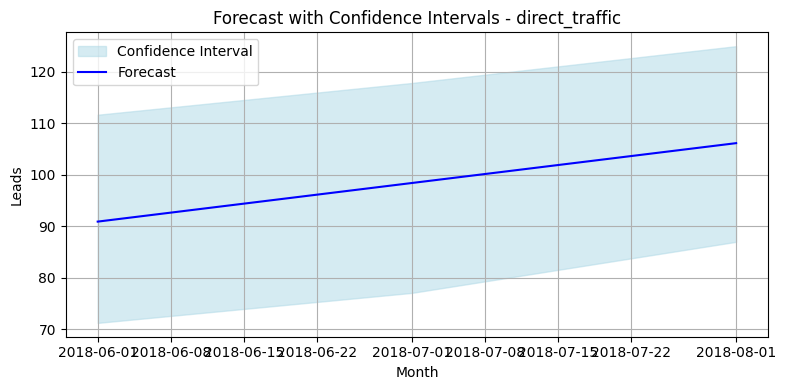

⚠️ High uncertainty for channel 'display':
           ds       yhat  relative_uncertainty
12 2018-06-01  16.389303              0.832911
13 2018-07-01  17.386212              0.809609
14 2018-08-01  18.416352              0.738991


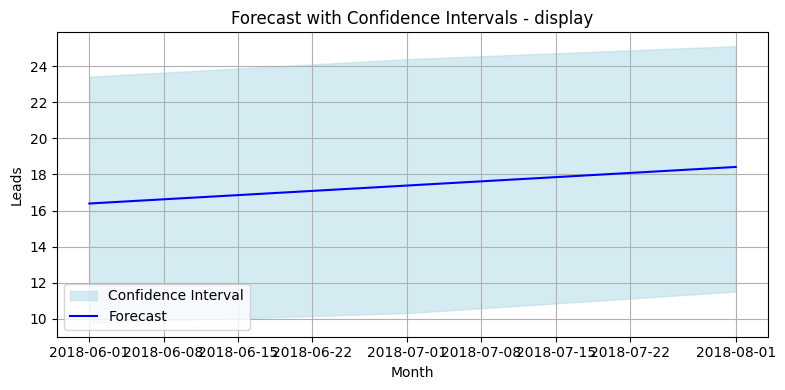

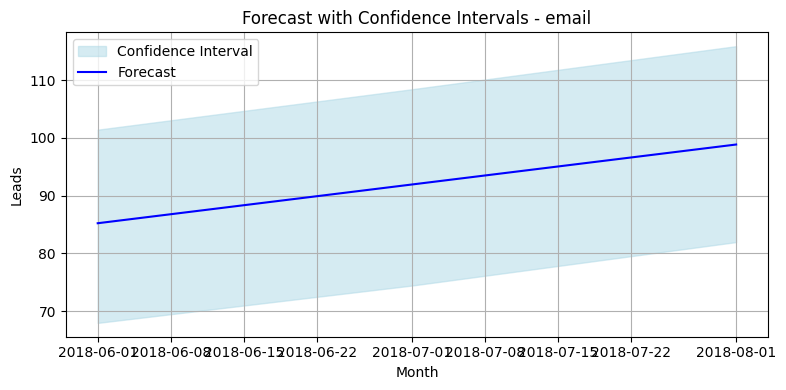

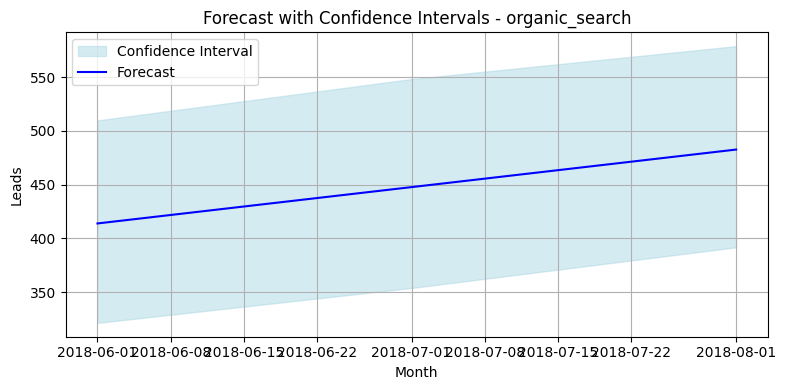

⚠️ High uncertainty for channel 'other':
           ds       yhat  relative_uncertainty
11 2018-06-01  23.335261              1.079379
12 2018-07-01  24.932577              1.019110
13 2018-08-01  26.583136              0.899699


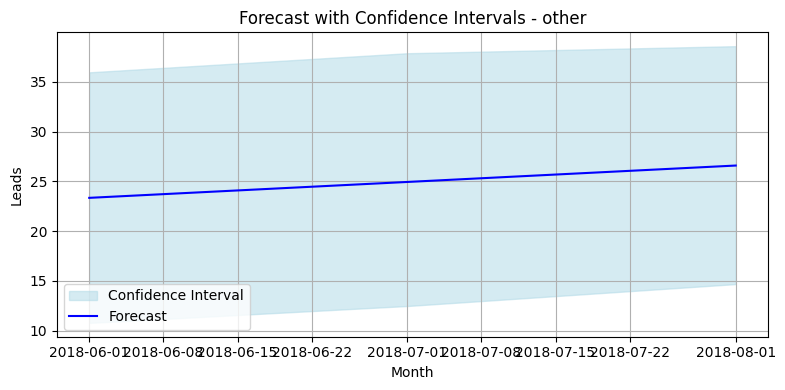

⚠️ High uncertainty for channel 'other_publicities':
           ds       yhat  relative_uncertainty
11 2018-06-01   9.927934              0.697444
12 2018-07-01  10.590053              0.712716
13 2018-08-01  11.274243              0.664923


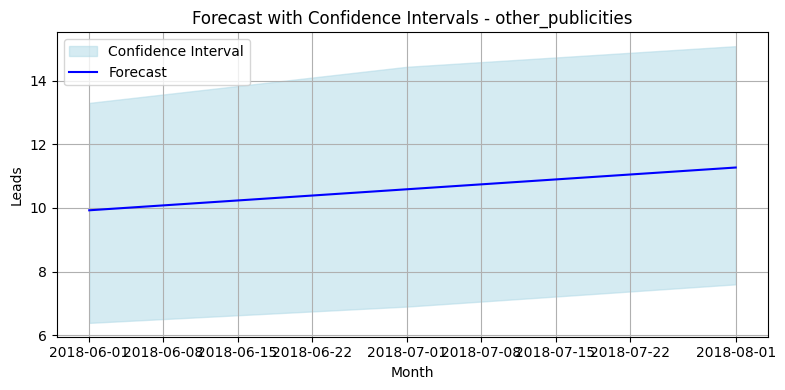

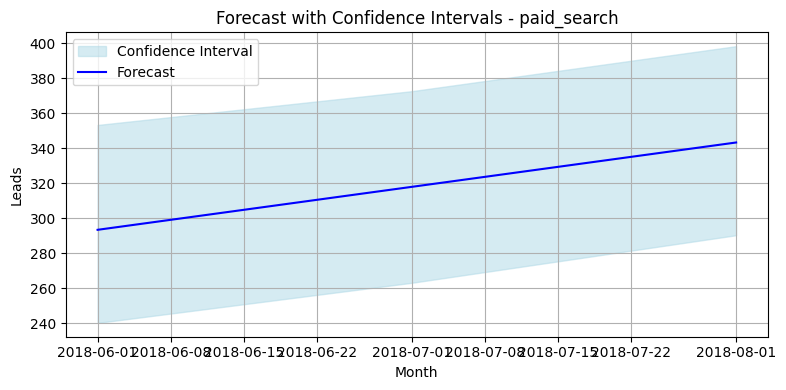

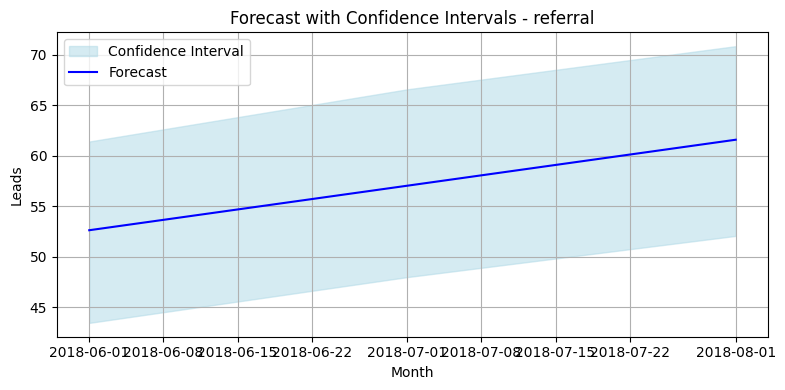

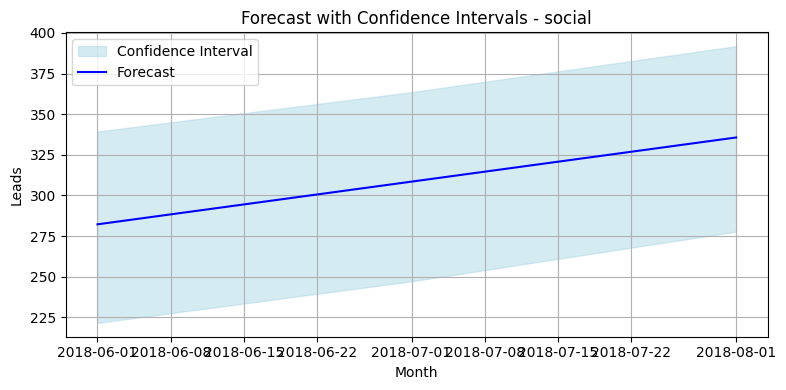

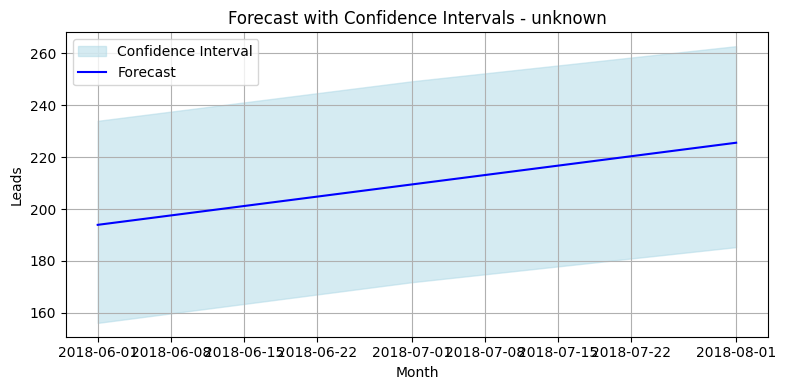

In [76]:
for channel in final_forecast['channel'].unique():
    forecast_future = final_forecast[final_forecast['channel'] == channel].copy()
    forecast_future['interval_width'] = forecast_future['yhat_upper'] - forecast_future['yhat_lower']
    forecast_future['relative_uncertainty'] = forecast_future['interval_width'] / forecast_future['yhat']

    # Append to overall forecast
    forecasts.append(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'interval_width', 'relative_uncertainty', 'channel']])

    # Optional: flag high uncertainty (> 50%)
    high_uncertainty = forecast_future[forecast_future['relative_uncertainty'] > 0.5]
    if not high_uncertainty.empty:
        print(f"⚠️ High uncertainty for channel '{channel}':")
        print(high_uncertainty[['ds', 'yhat', 'relative_uncertainty']])

    # Optional: plot forecast with confidence interval
    plt.figure(figsize=(8, 4))
    plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='lightblue', alpha=0.5, label='Confidence Interval')
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast', color='blue')
    plt.title(f"Forecast with Confidence Intervals - {channel}")
    plt.xlabel('Month')
    plt.ylabel('Leads')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Identify underperforming channels
From the above results, we can say that Organic Search is the main driver with ~29% of the total leads and 32% of the closed deals (it is important to note that our attribution model is single touch, therefore we might be understimating the importance of other channels at the beginning or middle of the decision process).

We also have ~21% of the leads with an Unknown channel, which account for ~14% of the closed deals and holds the highest CR of ~16% (this is a tracking challenge as these numbers can definitely change our perspective of what's working best).

With that context, the underperforming channels in terms of lead generation and also on CR are:
- other_publicites (with 0.8% of the leads and a CR of ~4.6%)
- other (with 0.5% of the leads and a CR of ~2.7)
- display (with 0.7% of the leads and a CR of ~5.1%)